In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
sns.set_context('paper', font_scale=1.75)

# Preparation data

In [ ]:
labs = pd.read_csv('data/labs_first_day.csv', index_col = [0, 1], header = [0, 1])
outcomes = pd.read_csv('data/outcomes_first_day.csv', index_col = 0)
labs.columns = labs.columns.droplevel() 

In [3]:
# For paper's tables
labs = pd.read_csv('data/labs_first_day_subselection.csv', index_col = [0, 1])
outcomes = pd.read_csv('data/outcomes_first_day_subselection.csv', index_col = 0)

### Analysis

In [4]:
labs

Anion gap  Bicarbonate  Blood urea nitrogen  Chloride  \
Patient Time                                                              
3       0.004167        NaN          NaN                  NaN       NaN   
        0.012500       23.0         13.0                 41.0     111.0   
        0.035417       22.0         11.0                 43.0     111.0   
        0.038889        NaN          NaN                  NaN       NaN   
        0.113194        NaN          NaN                  NaN       NaN   
...                     ...          ...                  ...       ...   
99995   0.226389        NaN          NaN                  NaN       NaN   
        0.296528        8.0         34.0                 10.0     100.0   
        0.403472        NaN          NaN                  NaN       NaN   
        0.525000        NaN          NaN                  NaN       NaN   
        0.771528        9.0         32.0                 13.0      99.0   

                  Creatinine  Glucose  Hematocrit  Hemoglobin  Magnesium  \
Patient Time                                                               
3       0.004167         NaN    140.0         NaN         NaN        NaN   
        0.012500         2.4    162.0        24.9         7.8        3.5   
        0.035417         2.5    281.0        25.6         8.2        2.6   
        0.038889         NaN    265.0         NaN         NaN        NaN   
        0.113194         NaN    267.0        30.0        10.1        NaN   
...                      ...      ...         ...         ...        ...   
99995   0.226389         NaN    110.0        27.0         9.0        NaN   
        0.296528         0.4    131.0        26.5         8.7        1.9   
        0.403472         NaN    128.0         NaN         NaN        NaN   
        0.525000         NaN    115.0         NaN         NaN        NaN   
        0.771528         0.5    110.0        28.7         9.3        1.9   

                  Mean corpuscular hemoglobin  \
Patient Time                                    
3       0.004167                          NaN   
        0.012500                         28.9   
        0.035417                         29.6   
        0.038889                          NaN   
        0.113194                          NaN   
...                                       ...   
99995   0.226389                          NaN   
        0.296528                         30.5   
        0.403472                          NaN   
        0.525000                          NaN   
        0.771528                         29.8   

                  Mean corpuscular hemoglobin concentration  \
Patient Time                                                  
3       0.004167                                        NaN   
        0.012500                                       31.3   
        0.035417                                       32.2   
        0.038889                                        NaN   
        0.113194                                        NaN   
...                                                     ...   
99995   0.226389                                        NaN   
        0.296528                                       32.9   
        0.403472                                        NaN   
        0.525000                                        NaN   
        0.771528                                       32.5   

                  Mean corpuscular volume  Platelets  Potassium  \
Patient Time                                                      
3       0.004167                      NaN        NaN        NaN   
        0.012500                     92.0      190.0        4.0   
        0.035417                     92.0      253.0        4.1   
        0.038889                      NaN        NaN        NaN   
        0.113194                      NaN        NaN        NaN   
...                                   ...        ...        ...   
99995   0.226389                      NaN        NaN       

<AxesSubplot:>

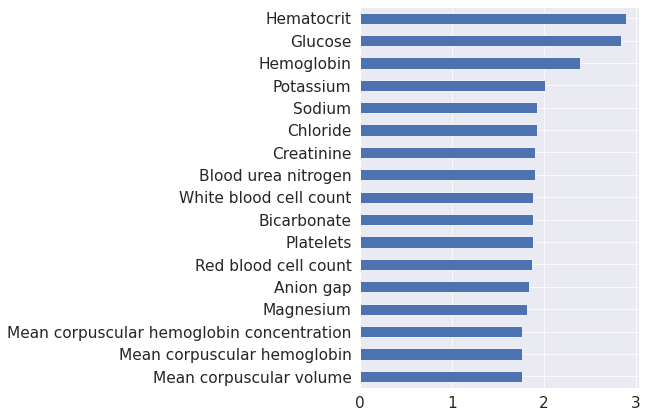

In [5]:
labs.groupby('Patient').count().mean().sort_values()[-20:].plot.barh(figsize = (5,7))

### How many different labs in this period ?

In [6]:
number_events = ((~labs.isna()).sum(axis = 1) > 0).groupby('Patient').sum()
number_events.describe()

count    30834.000000
mean         3.937699
std          3.412225
min          1.000000
25%          2.000000
50%          3.000000
75%          5.000000
max         35.000000
dtype: float64

### In hospial mortality

In [7]:
print("In hospital mortality: {:.2f} %".format(100 * (~outcomes.Death.isna()).mean()))

In hospital mortality: 13.86 %


# Analysis per admission day

In [8]:
weekday = [p for p in outcomes.index if outcomes.loc[p].Day <= 4]
weekend = outcomes.index.difference(weekday)

In [9]:
# To modify to study another group
outcome_we = outcomes.loc[weekend]
labs_we = labs.loc[weekend]

outcome_wd = outcomes.loc[weekday]
labs_wd = labs.loc[weekday]

In [ ]:
# Prepreocess ethnicity
ethnicity = outcomes.ETHNICITY.copy()
ethnicity[ethnicity.str.contains("ASIAN")] = 'Asian'
ethnicity[ethnicity.str.contains("HISPANIC")] = 'Hispanic'
ethnicity[ethnicity.str.contains("BLACK")] = 'Black'
ethnicity[ethnicity.str.contains("WHITE")] = 'White'
ethnicity[(ethnicity != "Asian") & (ethnicity != "Hispanic") & (ethnicity != "Black") & (ethnicity != "White")] = 'Other'

outcomes.ETHNICITY = ethnicity

In [ ]:
los_mean_we = outcome_we['LOS'].mean()
los_std_we = outcome_we['LOS'].std()
los_mean_wd = outcome_wd['LOS'].mean()
los_std_wd = outcome_wd['LOS'].std()
los = pd.DataFrame({'Mean': [outcomes['LOS'].mean(), los_mean_wd, los_mean_we],
                    'Std': [outcomes['LOS'].std(), los_std_wd, los_std_we]}, index = ['Population', 'Weekday', 'Weekend']).T

death_we = (~outcome_we['Death'].isna()).mean()
death_wd = (~outcome_wd['Death'].isna()).mean()
death = pd.DataFrame({'':[(~outcomes['Death'].isna()).mean(), death_wd, death_we]}, index = ['Population', 'Weekday', 'Weekend']).T*100

insurance_we = outcome_we['INSURANCE'].value_counts() / len(outcome_we)
insurance_wd = outcome_wd['INSURANCE'].value_counts() / len(outcome_wd)
insurance = pd.concat({"Population": outcomes['INSURANCE'].value_counts() / len(outcomes), "Weekday": insurance_wd, "Weekend": insurance_we}, 1)*100

ethnicity_we = ethnicity.loc[weekend].value_counts() / len(ethnicity.loc[weekend])
ethnicity_wd = ethnicity.loc[weekday].value_counts() / len(ethnicity.loc[weekday])
ethnicity = pd.concat({"Population": ethnicity.value_counts() / len(ethnicity), "Weekday": ethnicity_wd, "Weekend": ethnicity_we}, 1)*100

gender_we = outcome_we['GENDER'].replace({'M': 'Male', 'F': 'Female'}).value_counts() / len(outcome_we)
gender_wd = outcome_wd['GENDER'].replace({'M': 'Male', 'F': 'Female'}).value_counts() / len(outcome_wd)
gender = pd.concat({"Population": outcomes['GENDER'].replace({'M': 'Male', 'F': 'Female'}).value_counts() / len(outcomes), "Weekday": gender_wd, "Weekend": gender_we}, 1)*100

In [ ]:
analysis = pd.concat({'LOS': los,
           'Death': death,
           'Gender': gender,
           'Ethnicity': ethnicity,
           'Insurance': insurance})
print(analysis.to_latex(float_format="{:0.2f}".format))
analysis

In [ ]:
count_mean = labs.groupby('Patient').count().mean()
count_std = labs.groupby('Patient').count().std()
value_mean = labs.groupby('Patient').mean().mean()
value_std = labs.groupby('Patient').mean().std()

In [ ]:
tests = pd.DataFrame({('Number Test', 'Mean'): count_mean,
           ('Number Test', 'Std'):count_std, 
           ('Value', 'Mean'): value_mean, 
           ('Value', 'Std'): value_std})
print(tests.to_latex(float_format="{:0.2f}".format))
tests

In [ ]:
count_mean_we = labs_we.groupby('Patient').count().mean()
count_std_we = labs_we.groupby('Patient').count().std()
value_mean_we = labs_we.groupby('Patient').mean().mean()
value_std_we = labs_we.groupby('Patient').mean().std()

count_mean_wd = labs_wd.groupby('Patient').count().mean()
count_std_wd = labs_wd.groupby('Patient').count().std()
value_mean_wd = labs_wd.groupby('Patient').mean().mean()
value_std_wd = labs_wd.groupby('Patient').mean().std()

In [ ]:
import scipy.stats

In [ ]:
tests = pd.DataFrame({('Number Test', 'Weekday', 'Mean'): count_mean_wd, 
            ('Number Test', 'Weekend', 'Mean'): count_mean_we, 
            ('Number Test', 'Test', 'P Value'): [scipy.stats.ttest_ind(labs_we[i].groupby('Patient').count().dropna(), labs_wd[i].groupby('Patient').count().dropna())[1] for i in labs_wd.columns],
           ('Value', 'Weekday', 'Mean'): value_mean_wd, 
           ('Value', 'Weekend', 'Mean'): value_mean_we,
           ('Value', 'Test', 'P Value'): [scipy.stats.ttest_ind(labs_we[i].groupby('Patient').mean().dropna(), labs_wd[i].groupby('Patient').mean().dropna())[1] for i in labs_wd.columns],
           
          })
print(tests.loc[labs.groupby('Patient').count().mean().sort_values().index].to_latex(float_format="{:0.3f}".format))
tests

In [ ]:
ordered_test = labs.groupby('Patient').count().sum(1).to_frame(name = 'Total tests ordered').join(
    (outcomes.Day <= 4).rename("Admission").replace({False: "Weekend", True: "Weekday"})
    ).join(outcomes.Death.isna().rename("Outcome").replace({True: "Discharge", False: "Death"}))

In [ ]:
ax = sns.violinplot(x = "Outcome", y = "Total tests ordered", hue = "Admission", data = ordered_test, split = True, inner = 'quartile', palette = "flare", cut = 0)
plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), title = 'Admission day')
plt.ylim(17, 75)

# Analyze available labs

Subselect features to use.

In [ ]:
from FeatureAnalysis.analysis.eclat import eclat
from FeatureAnalysis.analysis.rendering import buildGraph

In [ ]:
missing_data = labs.groupby('Patient').count()
missing_data[missing_data <= 0] = np.nan
missing_data[0 < missing_data] = 1

In [ ]:
features = eclat(missing_data, minCount = 30000)
print(features)
buildGraph(features, mainBranch = True).render('examples/small')

In [ ]:
def next_feature(node):
    if len(node.children) == 0:
        return [node.name]
    return [node.name] + next_feature(node.children[0])

In [ ]:
# Remove patients with no values
selection = labs[next_feature(features.children[0])][next_feature(features.children[0])]
selection = (selection.groupby('Patient').count() == 0).sum(1) == 0
selection = selection.index[selection]

In [ ]:
labs[labs.index.get_level_values('Patient').isin(selection)][next_feature(features.children[0])]

In [ ]:
labs_subselection = labs[labs.index.get_level_values('Patient').isin(selection)][next_feature(features.children[0])].dropna(how = 'all')
outcomes_subselection = outcomes[outcomes.index.get_level_values('Patient').isin(labs_subselection.index.get_level_values('Patient'))]

In [ ]:
# Save subsets patients and labs
labs_subselection.to_csv('data/labs_first_day_subselection.csv')
outcomes_subselection.to_csv('data/outcomes_first_day_subselection.csv')

# Display observation process

Display a random selection for each outcomes of the observation process

In [ ]:
np.random.seed(42)

In [ ]:
n = 30
random_selection = {
    time: 
        {
            'Early Death\n(before end of week 1)': outcomes_time[(~outcomes_time.Death.isna()) & (outcomes_time.LOS < 7)].sample(n = n),
            'Later Death': outcomes_time[(~outcomes_time.Death.isna()) & (outcomes_time.LOS > 7)].sample(n = n),
            'Discharged': outcomes_time[outcomes_time.Death.isna()].sample(n = n) 
        } for time, outcomes_time in zip(['Weekday Admission', 'Weekend Admission'], [outcome_wd, outcome_we])
    }



In [ ]:
for l in np.random.choice(labs.columns, size = 5):
    labs_display = labs[l].dropna()

    fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10, 8), sharex = True, sharey = True)
    fig.suptitle(l)

    for j, time in enumerate(random_selection.keys()):
        ax[0, j].set_title(time)
        for i, cat in enumerate(random_selection[time].keys()):
            ax[i, j].axes.yaxis.set_ticks([])
            ax[i, j].set_xlim([0, 24])
            ax[i, 0].set_ylabel(cat)
            for k, patient in enumerate(random_selection[time][cat].index):
                ax[i, j].plot([0, 24], [k, k], ls = '--', alpha = 0.5, c = 'w')
                try:
                    data_patient = labs_display.loc[patient].index
                    ax[i, j].scatter(24 * data_patient, [k] * len(data_patient), alpha = 0.8, marker = 'x')
                except:
                    pass
    ax[-1, 1].set_xlabel('Time (in hours)')
    ax[-1, 0].set_xlabel('Time (in hours)')
    plt.tight_layout()
    plt.show()